In [1]:
# allow imports from local "src" directory
import sys
sys.path.append('..')

import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as pyplot
from matplotlib import cm
import plotly.express as px

import botorch
from botorch.models.gpytorch import GPyTorchModel

import pandas as pd
#%matplotlib inline
#%load_ext autoreload
#%autoreload 2
print(gpytorch.__version__)

/Users/valenetjong/opt/anaconda3/envs/FEGP/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.7.0


# Data import and preparation

In [10]:
# load data
fe_data = pd.read_csv('../data/KHM005_KHM006_quartz_HZO_samples2.csv', index_col=0)
#fe_data['log(RTA time)'] = np.log(fe_data['RTA time (sec)'])
# fe_data['Coersive Field'] = fe_data['Coersive Voltage +'] - fe_data['Coersive Voltage -']
fe_data.columns

Index(['Thickness (nm)', 'Flash voltage (kV)', 'Flash time (msec)',
       'Pr (uC/cm2), Pristine state', '2Pr (uC/cm2), Pristine state',
       'Predicted 2Pr', 'Coersive Voltage', 'Imprint', 'Endurance',
       'Max temperature (degC)', 'Duty Cycle', 'Num Pulses'],
      dtype='object')

In [7]:
fe_data.head()

,Thickness (nm),Flash voltage (kV),Flash time (msec),"Pr (uC/cm2), Pristine state","2Pr (uC/cm2), Pristine state",Predicted 2Pr,Coersive Voltage,Imprint,Endurance,Max temperature (degC),Duty Cycle,Num Pulses
1,10,2.0,2.0,1.39,2.78,NaN,0.49,-0.002,100000000.0,342,0.21,1
2,10,2.0,5.0,3.94,7.88,NaN,0.84,0.122,10000000.0,345,0.22,2
3,10,2.2,1.0,4.69,9.38,NaN,0.74,0.069,10000000.0,361,0.23,3
4,10,2.2,1.5,13.82,27.64,NaN,0.93,0.195,1000000.0,403,0.24,4
5,10,2.2,2.0,13.81,27.62,NaN,0.97,0.144,100000.0,427,0.34,5


In [11]:
# plot?...
fig = px.scatter_3d(fe_data, x='Flash voltage (kV)', y='Flash time (msec)', 
                        z='Pr (uC/cm2), Pristine state')
fig.update_layout(scene=dict(
                            # xaxis=dict(nticks=4, range=[200, 800])
                            # yaxis=dict(range=[0, 500])
                            ),
                   margin=dict(r=20, l=10, b=10, t=10)
                   )
fig.show()

In [26]:
# prep training data
from sklearn.preprocessing import StandardScaler
T_scaler = StandardScaler()

# filter training data 
mask = ~np.isnan(fe_data['Pr (uC/cm2), Pristine state'])
train_x = torch.Tensor([fe_data['Flash voltage (kV)'][mask].values, 
                       fe_data['Flash time (msec)'][mask].values, 
                       fe_data['Duty Cycle'][mask].values,
                       fe_data['Num Pulses'][mask].values]).T
# train_x = torch.Tensor(T_scaler.fit_transform(train_x))
train_y = torch.Tensor(fe_data['Pr (uC/cm2), Pristine state'][mask].values)

# define grid between bounds of RTA time, RTA temp
# grid_bounds = [(train_x[:,0].min(), train_x[:,0].max() ), 
#                 (train_x[:,1].min(), train_x[:,1].max() )]
num_params = train_x.size(dim=1)
grid_bounds = [(train_x[:,i].min(), train_x[:,i].max()) for i in range(num_params)]
grid_size = 20
grid = torch.zeros(grid_size, num_params)

for i in range(num_params):
    grid_diff = float(grid_bounds[i][1] - grid_bounds[i][0]) / (grid_size - 2)
    grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, 
                                grid_bounds[i][1] + grid_diff, grid_size)

# Set up grid for predictions
n = 30 # number of points in grid, different from one supplied to GP
test_grid = torch.zeros(n, num_params)
for i in range(num_params): # Creates a grid s.t. grid[:, i] is the vector along dimension i
    grid_diff = float(grid_bounds[i][1] - grid_bounds[i][0]) / (n - 2)
    test_grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, 
                                grid_bounds[i][1] + grid_diff, n)

test_x = torch.zeros(int(pow(n, 2)), num_params)

for i in range(n): #Basically making grid 
    for j in range(n):
        for k in range(num_params):
            test_x[i*n + j][k] = test_grid[i, k]

tensor([[ 1.9643,  0.3393,  0.1911,  0.2857],
        [ 1.9643,  0.3393,  0.1911,  0.2857],
        [ 1.9643,  0.3393,  0.1911,  0.2857],
        ...,
        [ 3.0357,  5.1607,  0.7589, 21.7143],
        [ 3.0357,  5.1607,  0.7589, 21.7143],
        [ 3.0357,  5.1607,  0.7589, 21.7143]])


In [8]:
def intermediate_plot(f, ax, obs, title):
    im = ax.imshow(obs.mean.view(n, n), aspect='equal',
                extent=[grid_bounds[0][0].item(), grid_bounds[0][1].item(),
                            grid_bounds[1][0].item(), grid_bounds[1][1].item()])
    f.colorbar(im)
    # ax.scatter(train_x[:,0], train_x[:,1], c=train_y)
    ax.set_title(title)

# Build GP Classes/Models
A bit of pytorch-esque construction here, but the important parts to take note of are the kernel / mean modules and `noises` array.  

In [10]:
# initialize GP model
class GridGP(gpytorch.models.ExactGP, GPyTorchModel):

    _num_outputs = 1
    def __init__(self, train_x, train_y, likelihood):
        super(GridGP, self).__init__(train_x, train_y, likelihood)  
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
                                gpytorch.kernels.RBFKernel(ard_num_dims=4) )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# 0-observation noise case
# likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Case for fixed observation noise.  This is set to 5 based on the magnitude of
# the data, but can be played with.  
noises = torch.ones(len(train_x)) * 5.0
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noises)
model = GridGP(train_x, train_y, likelihood)

model.covar_module.base_kernel.lengthscale = torch.Tensor([1, 1, 1, 1])
print(likelihood.noise)

tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5.])


In [11]:
# Train and evaluate the model.  (short form)
from botorch.optim.fit import fit_gpytorch_torch

# initialize the log-likelihood, and supply it to the GP.  This will be used to 
# make predictions.  
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
mll.train()
# convenience function for fitting gpytorch models
fit_gpytorch_torch(mll, options={'maxiter':2000, 'lr':10}) 
mll.eval()

Iter 10/2000: 5.127506256103516


ExactMarginalLogLikelihood(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (model): GridGP(
    (likelihood): FixedNoiseGaussianLikelihood(
      (noise_covar): FixedGaussianNoise()
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [12]:
# Training loop (long form, for inspection of results during training)
training_iter = 2000

# Place both the model and likelihood in training mode
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=10)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()

    output = model(train_x)

    # backpropogate error
    loss = -mll(output, train_y)
    loss.backward()

    if i % 100 == 0: 
        print('Iter %d/%d - Loss: %.3f  lengthscale1: %s   noise: %s' % (
        i+1, training_iter, loss.item(), 
        model.covar_module.base_kernel.lengthscale.detach().numpy(),
        model.likelihood.noise.detach().numpy()
        )) 

        # # get a quick snapshot of intermediate 
        # model.eval()
        # likelihood.eval()
        # with torch.no_grad(), gpytorch.settings.fast_pred_var():
        #     obs = likelihood(model(test_x))

        #     f, ax = plt.subplots(1, 1, figsize=(4,3))
        #     intermediate_plot(f, ax, obs, f'iter {i+1}/{training_iter}')
        # model.train()
        # likelihood.train()


    optimizer.step()

Iter 1/2000 - Loss: 5.177  lengthscale1: [[43.00877 45.33593]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 101/2000 - Loss: 4.709  lengthscale1: [[40.14618  43.882904]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 201/2000 - Loss: 4.657  lengthscale1: [[39.605164 43.8865  ]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 301/2000 - Loss: 4.590  lengthscale1: [[38.50257  43.888165]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 401/2000 - Loss: 4.508  lengthscale1: [[36.659454 43.89898 ]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 501/2000 - Loss: 4.408  lengthscale1: [[33.879963 43.91786 ]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 601/2000 - Loss: 4.281  lengthscale1: [[29.944416 43.942883]]   noise: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Iter 701/2000 - L

# Make and plot predictions

In [15]:
# make predictions (whether by long or short form)
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # also use mll from short form 
    obs = likelihood(model(test_x), noise=(torch.ones(len(test_x))*5))
# print(f'train data: {fe_data["2Pr (uC/cm2), Pristine state"][1]}')
# print(f'observed: {obs.mean}')

In [16]:
obs.covariance_matrix.shape

torch.Size([900, 900])

# Make predictions and plot the mean surface

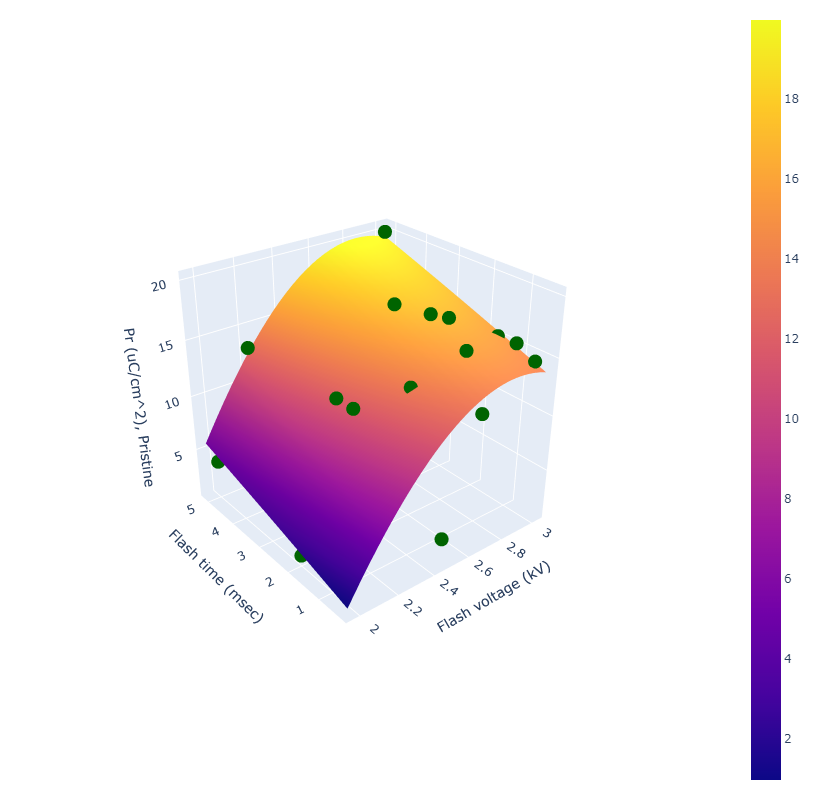

In [17]:
# non-log scale 3D plot

pred_labels = obs.mean.view(n, n)
# plot?...
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=pred_labels.numpy().T, x=test_grid[:,0], y=test_grid[:,1], name='GP regression')])
fig.add_trace(go.Scatter3d(x=train_x[:,0].numpy(),y=train_x[:,1].numpy(),  
                        z=train_y.numpy(), mode='markers', marker={'color':'darkgreen'}, name='training data'))
fig.update_layout( width=1000, height=800,
                  legend=dict(orientation="h", yanchor="top", y=1.02, xanchor="left",x=1),
                   margin=dict(r=20, l=10, b=10, t=10), 
                    scene=dict(
                    xaxis_title="Flash voltage (kV)",
                    yaxis_title="Flash time (msec)",
                    zaxis_title='Pr (uC/cm^2), Pristine')
                )
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-2, y=-2.5, z=1.75)
)

fig.update_layout(scene_camera=camera)
fig.show()

In [15]:
# # log scale
# pred_labels = obs.mean.view(n, n)
# # plot?...
# import plotly.graph_objects as go
# fig = go.Figure(data=[go.Surface(z=pred_labels.numpy().T, x=test_grid[:,0], y=test_grid[:,1], name='GP regression')])
# fig.add_trace(go.Scatter3d(x=train_x[:,0].numpy(),y=train_x[:,1].numpy(),  
#                         z=train_y.numpy(), mode='markers', marker={'color':'darkgreen'}, name='trianing data'))
# fig.update_layout( #width=1000, height=800,
#                   legend=dict(orientation="h", yanchor="top", y=1.02, xanchor="left",x=1),
#                    margin=dict(r=20, l=10, b=10, t=10), 
#                     scene=dict(
#                     xaxis_title="RTA temperature (C)",
#                     yaxis_title="RTA time (sec)",
#                     zaxis_title='2Pr (uC/cm2), Pristine')
#                 )
# fig.show()

# Evaluate acquisition functions
This is a bit over-engineered at the moment, as it was built to allow use of the acquisition functions in bayesian optimization loops (botorch functionality).  The below cells should suffice to return the needed results.  

In [16]:
# Evaluate acquisition functions on current predictions (observations)

from src.acq_funcs import EI, PI, cust_acq, thompson
bounds = [1,1]

# Probability of Improvement
PI_acq = PI(obs, bounds, train_y)
PI_acq_shape = PI_acq.detach().numpy().reshape(30,30).T

# Expected Improvement
EI_acq = EI(obs, bounds, train_y)
EI_acq_shape = EI_acq.detach().numpy().reshape(30,30).T

# Custom Acquisition (something I was playing with)
ca_acq = cust_acq(obs, bounds, train_y)
ca_acq_shape = ca_acq.detach().numpy().reshape(30,30).T

# Thompson Acquisition function
th_acq = thompson(obs, bounds, train_y)
th_acq_shape = th_acq.detach().numpy().reshape(30,30).T
# fig = go.Figure(data=[go.Surface(z=acq, x=test_grid[:,0], y=test_grid[:,1])])


In [17]:
ei = np.unravel_index(EI_acq_shape.argmax(), EI_acq_shape.shape)
pi = np.unravel_index(PI_acq_shape.argmax(), PI_acq_shape.shape)
ca = np.unravel_index(ca_acq_shape.argmax(), ca_acq_shape.shape)
th = np.unravel_index(th_acq_shape.argmax(), th_acq_shape.shape)

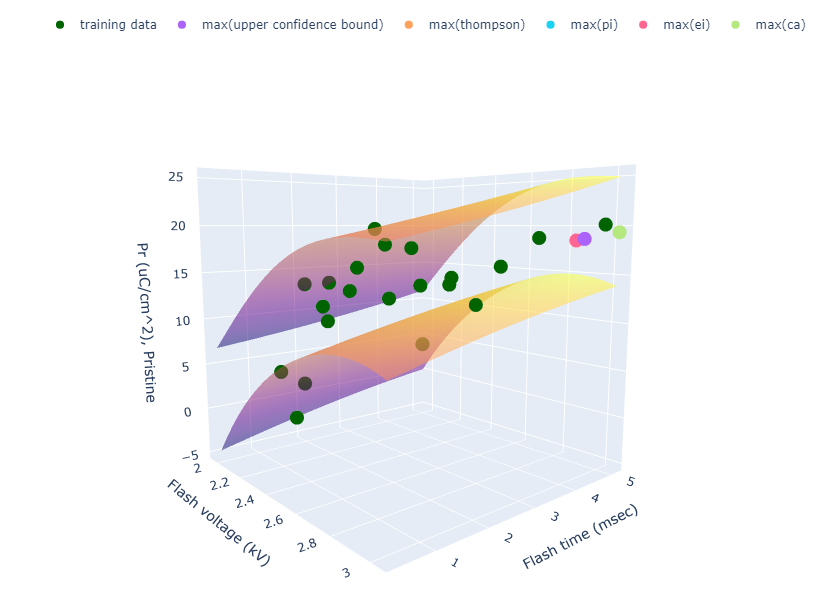

In [18]:
# Plot the acquisition function results alongside the confidence bound surfaces
pred_var = obs.variance.view(n, n).detach().numpy().T
lower, upper = obs.confidence_region()
upper_surf = upper.detach().numpy().reshape(30,30).T
lower_surf = lower.detach().numpy().reshape(30,30).T

ucb = np.unravel_index(upper_surf.argmax(), upper_surf.shape)
max_var = np.unravel_index(pred_var.argmax(), pred_var.shape)
ei = np.unravel_index(EI_acq_shape.argmax(), EI_acq_shape.shape)
pi = np.unravel_index(PI_acq_shape.argmax(), PI_acq_shape.shape)

# plot?...
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z = upper_surf, x=test_grid[:,0], y=test_grid[:,1], opacity=0.5, showscale=False)])
fig.add_trace(go.Surface(z = lower_surf, x=test_grid[:,0], y=test_grid[:,1], opacity=0.5, showscale=False))
fig.add_trace(go.Scatter3d(x=train_x[:,0].numpy(), y=train_x[:,1].numpy(), 
                            z=train_y.numpy(), mode='markers', name='training data', marker={'color':'darkgreen'}))

fig.add_trace(go.Scatter3d(x=test_grid[ucb[1], 0].numpy(), y=test_grid[ucb[0], 1].numpy(), 
                            z=[pred_labels[ucb[0], ucb[1]]], mode='markers', name='max(upper confidence bound)')) 
fig.add_trace(go.Scatter3d(x=test_grid[th[1], 0].numpy(), y=test_grid[th[0],1].numpy(), 
                            z=[pred_labels[th[0], th[1]].detach().numpy()], mode='markers', name='max(thompson)')) 
fig.add_trace(go.Scatter3d(x=test_grid[pi[1], 0].numpy(), y=test_grid[pi[0], 1].numpy(), z=[pred_labels[pi[0], pi[1]]], mode='markers', name='max(pi)'))

fig.add_trace(go.Scatter3d(x=test_grid[ei[1], 0].numpy(), y=test_grid[ei[0], 1].numpy(), z=[pred_labels[ei
[0], ei[1]]], mode='markers', name='max(ei)'))

fig.add_trace(go.Scatter3d(x=test_grid[ca[1], 0].numpy(), y=test_grid[ca[0], 1].numpy(), z=[pred_labels[ca[0], ca[1]]], mode='markers', name='max(ca)'))


fig.update_layout( width=800, height=600,
                  margin=dict(r=20, l=10, b=10, t=10),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right",x=1),
                  scene=dict(
                    xaxis_title="Flash voltage (kV)",
                    yaxis_title="Flash time (msec)",
                    zaxis_title='Pr (uC/cm^2), Pristine')
                  )
fig.show()

In [70]:
# Simply print the locations of the suggested points
print(test_grid[ei[1], 0], test_grid[ei[0], 1])
print(test_grid[pi[1], 0], test_grid[pi[0], 1])
print(test_grid[ca[1], 0], test_grid[ca[0], 1])
print(test_grid[ucb[1], 0], test_grid[ucb[0], 1])
print(test_grid[th[1], 0], test_grid[th[0], 1])
print(test_grid[max_var[1], 0], test_grid[max_var[0], 1])

tensor(415.0862) tensor(114.9384)
tensor(415.0862) tensor(114.9384)
tensor(453.8793) tensor(451.8842)
tensor(402.1552) tensor(451.8842)
tensor(712.5000) tensor(388.7069)
tensor(647.8448) tensor(430.8251)


In [71]:
print(pred_labels[ei[0], ei[1]])
print(pred_labels[pi[0], pi[1]])
print(pred_labels[ca[0], ca[1]])
print(pred_labels[ucb[0], ucb[1]])
print(pred_labels[th[0], th[1]])
print(pred_labels[max_var[0], max_var[1]])


tensor(36.4777)
tensor(36.4777)
tensor(25.6007)
tensor(23.9889)
tensor(26.0637)
tensor(26.0657)


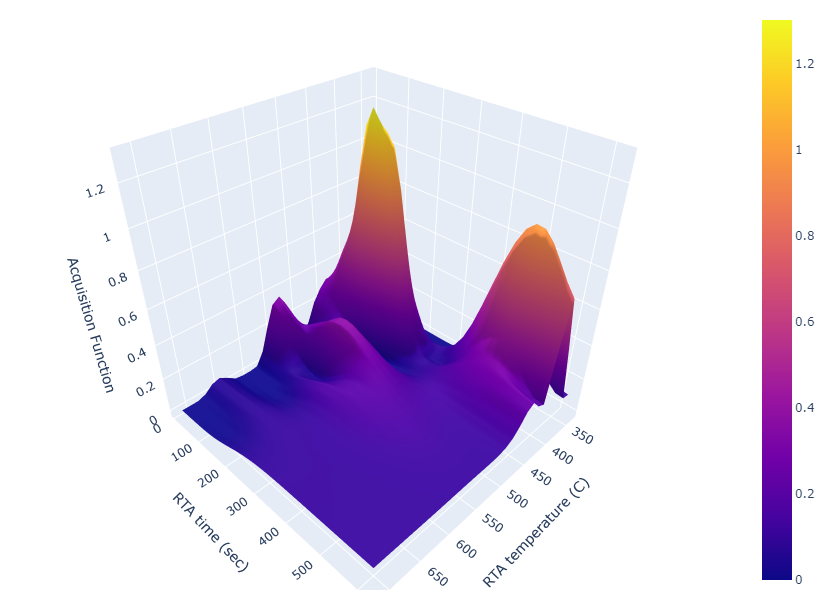

In [15]:
# look at acq_func manifold
fig = go.Figure(data=[go.Surface(z=EI_acq_shape, x=test_grid[:,0], y=test_grid[:,1])])
fig.add_trace(go.Scatter3d(x=test_grid[pi[1], 0].numpy(), y=test_grid[pi[0], 1].numpy(), z=[PI_acq_shape[pi[0], pi[1]]], mode='markers', name='max(pi)'))
fig.update_layout( width=1000, height=600,
                  margin=dict(r=20, l=10, b=10, t=10),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right",x=1),
                  scene=dict(
                    xaxis_title="RTA temperature (C)",
                    yaxis_title="RTA time (sec)",
                    zaxis_title='Acquisition Function')
                  )
fig.show()

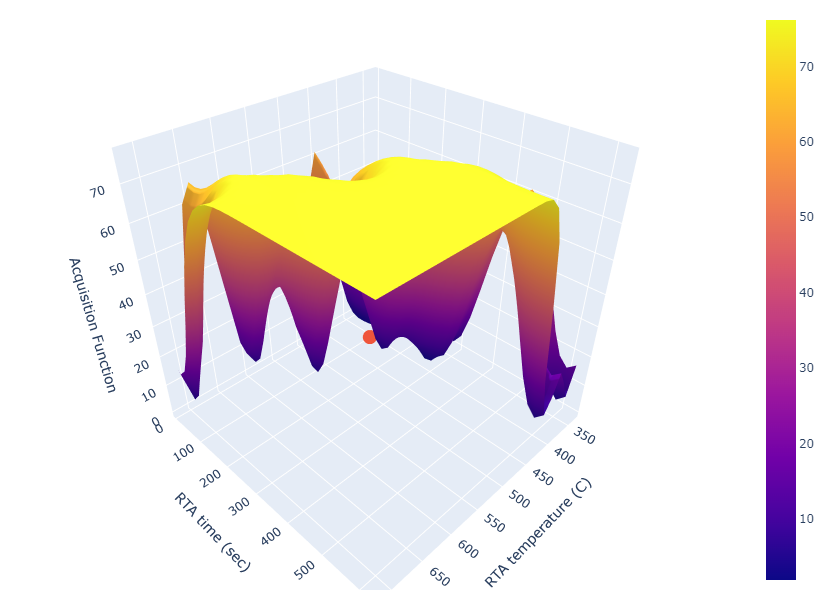

In [23]:
# look at acq_func manifold
fig = go.Figure(data=[go.Surface(z=pred_var, x=test_grid[:,0], y=test_grid[:,1])])
fig.add_trace(go.Scatter3d(x=test_grid[pi[1], 0].numpy(), y=test_grid[pi[0], 1].numpy(), z=[PI_acq_shape[pi[0], pi[1]]], mode='markers', name='max(pi)'))
fig.update_layout( width=1000, height=600,
                  margin=dict(r=20, l=10, b=10, t=10),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right",x=1),
                  scene=dict(
                    xaxis_title="RTA temperature (C)",
                    yaxis_title="RTA time (sec)",
                    zaxis_title='Acquisition Function')
                  )
fig.show()